In [55]:
#Run these codes to import necessary libraries 

import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plots
import pandas as pd
%matplotlib inline
from datascience import Table
from datascience import *

# Diabetes Classifier - Produced by Huong Nguyen

References:

The diabetes data set is obtained and downloaded from the source: https://www.kaggle.com/datasets/mathchi/diabetes-data-set

The techniques applied in this project are what I have learned from the Data Science course - Data 8 instructed by UC Berkeley Professors and taken at Pasadena City College.  

In [102]:
pd.read_csv('C:\\Users\\huong\\diabetes.csv')
df = pd.read_csv('diabetes.csv')

In [103]:
diabetes = Table().read_table('diabetes.csv')
diabetes
 

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,0,0,0,0.232,54,1


The data collects diagnostic measurements on 768 21-year-old female patients from the National Institute of Diabetes and Digestive and Kidney Diseases. 
The objective of this data collection is to predict whether a patient is positive or negative to diabetes test. 
The "Outcome" indication, which later on will be renamed to "Class" for unified language purpose, demonstrates value of "0" and "1". Class value "1" interpreted as "tested positive for diabetes" and "0" as "tested negative for diabetes". 

The method called kNN or KNN (k-Nearest Neighbors Algorithm) is known as one of the methods of classification. 
The general idea is to build a classifier to predict the class of a new individual, based on the attributes and identified classes ( 0 or 1) of the training data set. 

In this project, I will build a classifier to predict whether a new 21-year-old female patient is positive or negative to diabetes based on the attributes of her diagnostic measurements and utilizing the training data set that is provided. In other words, to classify the new patient as diabetic or not, I find a "k" number of patients in the training set who are "nearest" to her, and then use the majority class of those patients as the prediction for her. The "nearest" patients have similar corresponding measurements with her, so I might expect them to receive the same classification result. 

I will pick out 2 attributes "BloodPressure" and "Glucose" from the data set to build the classifier. I will also divide the data set to a training and a testing set. The training set is used to build the classifier.
Then once the classifer is built, I will test its accuracy against the testing set. 

In [104]:
#This is how the data set table is simplified after picking out the 2 attributes 

class_table = diabetes.select("BloodPressure","Glucose","Outcome")
class_table

BloodPressure,Glucose,Outcome
72,148,1
66,85,0
64,183,1
66,89,0
40,137,1
74,116,0
50,78,1
0,115,0
70,197,1
96,125,1


The next step is to convert the measurements of attributes "Glucose" and "Blood Pressure" to a same kind of unit, which is the standard unit. For the purpose of calculation and comparisons, we will need the conversion of unit so that we won't have to worry about the scale of each different attribute. Each attribute is stored in an array of values. 

Following is the function for the conversion and the new table "classified_table" with the 2 attributes Glucose and BloodPressure data being converted. The "Outcome" column will also be renamed to "Class" for the unified language. We will use this classified_table for the remaining parts of this project. 

In [105]:
def standard_units(attribute):
    """Converts an array to standard units"""
    return (attribute - np.average(attribute))/np.std(attribute)


In [106]:
classified_table = Table().with_columns(
                 "BloodPressure", standard_units(class_table.column("BloodPressure")),
                 "Glucose", standard_units(class_table.column("Glucose")),
                 "Class", class_table.column("Outcome"))
classified_table

BloodPressure,Glucose,Class
0.149641,0.848324,1
-0.160546,-1.1234,0
-0.263941,1.94372,1
-0.160546,-0.998208,0
-1.50469,0.504055,1
0.253036,-0.153185,0
-0.98771,-1.34248,1
-3.5726,-0.184482,0
0.0462453,2.38188,1
1.39039,0.128489,1


Below is the visualization of the class_table above:

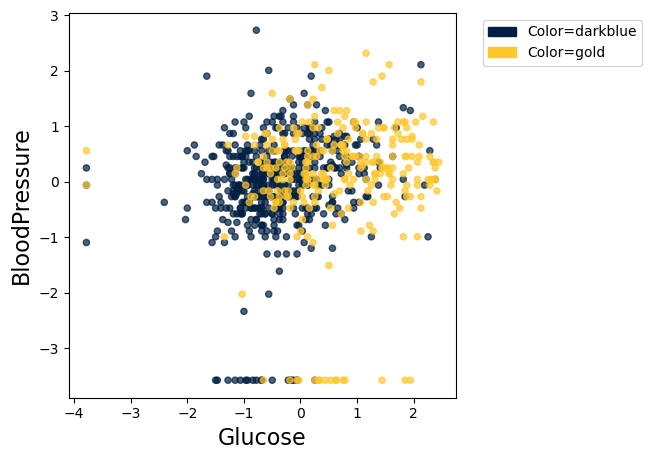

In [108]:
color_table = Table().with_columns("Class", make_array(0,1), "Color", make_array('darkblue', 'gold'))
scatter_table = classified_table.join('Class', color_table)
scatter_table.scatter("Glucose", "BloodPressure", group = "Color")

Every dot on the plot represents a patient's diagnostic result of diabetes with the tested measurements of their Blood Pressure and Glucose. 
Looking at the scatter plot, the dark blue dots are diabetes negative and the gold dots are diabetes positive patients.
Suppose, I am given a new 21-year-old female patient's Blood Pressure and Glucose measurements, my classifier will need to diagnose whether this new patient has positive or negative to diabetes by calculating the distances between that patient to the other "k" nearest patients, then choose the the majority votes among the classes of the "k" nearest patients, and classify that vote as the new patient's result.  

As a standard accuracy in machine learning, I will also need to check the accuracy of my classifier to be above 70% to be sufficient on this project. 

Next, I will define a function to calculate the distance between 2 points; which are 1 point of the measurements of an existing patient data (with known class) and 1 point of measurements of a new patient (need to predict the class). 
This distance is called Euclidean distance and the formula comes from the Pythogorean theorem; I will need to find the distance of a right triangle, which is the hypotenuse, by using the given side lengths. 

In [109]:
# Find the distance between points when there are two attribute measurements of each patient  

def distance(point1, point2):
    """Returns the Euclidean distance between point1 and point2
    Each argument is an array containing the coordinates of a point."""
    return np.sqrt(np.sum((point1 - point2)**2))

The following is an example of how this distance function is used when applying the function to 2 patients's attributes. 

In [110]:
example = classified_table.drop("Class")
example

BloodPressure,Glucose
0.149641,0.848324
-0.160546,-1.1234
-0.263941,1.94372
-0.160546,-0.998208
-1.50469,0.504055
0.253036,-0.153185
-0.98771,-1.34248
-3.5726,-0.184482
0.0462453,2.38188
1.39039,0.128489


In [111]:
# An example of distance between 2 points

distance(np.array(example.row(0)), np.array(example.row(1)))

1.9959699487757707

The next step is to split the data set to half randomized patients for a training set and the other half for a test set. 

The training set is used to build the classifier by calculating the distances between one point on the training set with the other points on the training set, then check to see if the class of that one point matches with what is already known. 

The testing set is then used to check the accuracy of the built classifier by computing the proportion of the time the classifier is correct. This proportion is an indication of an estimate of the correct percentage of all new patients (on the testing set) whose class the classifier will accurately predict. 

In [85]:
# Split the classified_table data set to half 

total_patients = classified_table.num_rows
half_patients = total_patients / 2
print("Total of patients in the whole data set is", total_patients) 
print("Half of patients in each test and training set is","%d" %half_patients)

shuffled_classified = classified_table.sample(with_replacement=False)
training_set = shuffled_classified.take(np.arange(384))
test_set = shuffled_classified.take(np.arange(384, 768))
 


Total of patients in the whole data set is 768
Half of patients in each test and training set is 384


In [86]:
# This is the training set 

training_set 

BloodPressure,Glucose,Class
0.976805,1.47427,1
1.0802,-1.15469,0
-0.574128,-1.18599,0
0.0462453,0.78573,1
-0.884314,-1.21729,0
0.149641,1.81854,1
0.821712,1.97502,1
0.253036,1.13,0
-0.367337,-0.434859,1
0.304734,-0.497453,0


In [87]:
# This is the test set 

test_set

BloodPressure,Glucose,Class
0.666618,-0.810425,1
0.873409,1.0987,1
-0.677523,0.78573,0
-3.5726,-0.184482,0
-0.884314,-0.904316,0
0.0462453,-1.65545,0
0.459827,-0.0279963,0
-3.5726,-1.27988,0
-0.574128,-1.0295,0
-0.212243,-1.1234,0


I will then define the following function to calculate the distances between each point on the training set and a new point being given to predict. This is part of the classifer building using the training set data. 

In [88]:
def all_distances(training, new_point):
    """Returns an array of distances between each point
    in the trainining set and the new point"""
    attributes = training.drop("Class")
    def distance_from_point(row):
        return distance(np.array(new_point), np.array(row))
    return attributes.apply(distance_from_point)

The next function being defined is used to create a new table containing the available data in the training set with an additional column listing out the distances calculated in the previous step. 

In [89]:
def table_with_distances(training, new_point):
    """Returns a table combined the training table
    with a column of distances from a new_point"""
    return training.with_column("Distance", all_distances(training, new_point))

I will then define a function that takes the data set from the training table, a new point to be predicted and a number "k" neighbors. This function helps to produce a table with the "k" nearest neighbors and their classes with the distances being calculated. I will then use these neighbors for the final result of the classification of the new point. 

In [90]:
def closest(training, new_point, k):
    """Returns a table of the k rows of the augmented table above
    showing the k neighbors of smallest distances"""
    with_dists = table_with_distances(training, new_point)
    sorted_by_distance = with_dists.sort("Distance")
    topk = sorted_by_distance.take(np.arange(k))
    return topk

The following example shows how the closest function being applied: 

This train_point from the training_set is used as a new_point to be predicted its class.
We can see its attributes' measurements and its known class. 
The resulted class will need to match with this known class.

In [91]:
train_point = training_set.row(4)
train_point

Row(BloodPressure=-0.88431424528869484, Glucose=-1.2172877969596361, Class=0)

The class of train_point is known as 0. As a effective classfier, we want to expect the result of the classifier to produce out the class of train_point is 0, which is negative to diabetes patient. 

In [92]:
# I will drop the "known" class and implement this row of attributes' measurements to 
# the previous function "closest" for calculation of the nearest neighbor distances.

train_point = training_set.drop("Class").row(4)
train_point

Row(BloodPressure=-0.88431424528869484, Glucose=-1.2172877969596361)

Since the train_point is part of the training_set, I will expect that the first nearest neighbor distance is 0, which is its own train_point. The remaining nearest neighbors are the other 4 as I choose k to be 5 neighbors. 

About choosing the number "k" of neighbors, this is varied and is picked by the further technique that is not in the scope of the course yet. Therefore, for now, I will go with a "k" that is most reasonable. 

In [93]:
# Apply "closest" function to the training_set and the train_point

closest(training_set, train_point, 5)

BloodPressure,Glucose,Class,Distance
-0.884314,-1.21729,0,0
-0.98771,-1.15469,0,0.120866
-0.98771,-1.34248,1,0.162366
-0.729221,-1.27988,0,0.167248
-0.884314,-1.46766,0,0.250377


The following function counts the numbers of each class in the neighbors and returns which class is the majority vote. 

In [94]:
def majority(topkclasses):
    """Takes the majority vote on the class in k neighbors"""
    ones = topkclasses.where("Class", are.equal_to(1)).num_rows
    zeros = topkclasses.where("Class", are.equal_to(0)).num_rows
    if ones > zeros:
        return 1
    else:
        return 0 
    

This following final function is the built classifier. 

It takes in arguments of the new_point, training_set data and the number of neighbors. Then it will do the classify process to 
produce the prediction of the new_point's class.

In [95]:
def classify(training, new_point, k):
    """Returns the predicition on the class of the new point.
    This is the built classifer"""
    closestk = closest(training, new_point, k)
    topkclasses = closestk.select("Class")
    return majority(topkclasses)

Now, to follow up with the previous example train_point prediction, I will apply the built classifier "classify" to the training_set and the selected train_point.

In [96]:
classify(training_set, train_point, 5)


0

The predicted class is 0, negative to diabetes, which matches with the known class of the train_point. This proves that the classifier works effectively. 

Let's apply the classifier on another train_point_2 in the training set. 

In [97]:
train_point_2 = training_set.row(11)
train_point_2


Row(BloodPressure=0.45982725200327884, Glucose=-0.15318485583915073, Class=0)

In [98]:
train_point_2 = training_set.drop("Class").row(11)


In [99]:
classify(training_set, train_point_2, 5)

0

Bingo! The classfier works on this train_point_2 as well. The known class is "0" which is negative diabetes patient and it matches with the prediction of the classifier.  

We have built our classifier and implemented it on some of the training points
from the training set. 
The outcome matches with the class of the corresponding training point. 
Now, we will check the accuracy of the classifier with the testing set.  

The following functions will identify the matching results of class between the test_set and the results from the classifier's prediction, applying to the whole test_set. Then, it produces the output that is the proportion of the accuracy performance between the classifier and the test_set. 

In [100]:
def count_zero(array):
    """Counts the number of 0's in an array"""
    return len(array) - np.count_nonzero(array)

def count_equal(array1, array2):
    """Takes two numerical arrays of equal length and
    counts the indices where the two are equal"""
    return count_zero(array1 - array2)

def evaluate_accuracy(training, test, k):
    test_attributes = test.drop("Class")
    def classify_testrow(row):
        return classify(training, row, k)
    c = test_attributes.apply(classify_testrow)
    return count_equal(c, test.column("Class")) / test.num_rows

I now use the function evaluate_accurary to check the accuracy of the classifier. 

In [101]:
evaluate_accuracy(training_set, test_set, 5)

0.7291666666666666

The accuracy fluctuates in the range of 70% to 74%, varied upon the shuffling training and test sets. This passes the standard that is set at the beginning. 

This concludes my classifier building process using kNN method to predict a new 21-year-old female patient on diabetes diagnosis using 2 attributes of measurements, which are Glucose and Blood Pressure of the patient.  